In [3]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import sklearn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
from torchvision import utils
from IPython import embed

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.5,), (0.5))])

mnist_trainset = datasets.MNIST(root='./DATA', train=True, download=True, transform=transform)

In [6]:
batchsize = 128
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batchsize, shuffle=True)

print("Training dataset size: ", len(mnist_trainset))
print("Training dataloader size: ", len(train_dataloader))

Training dataset size:  60000
Training dataloader size:  469


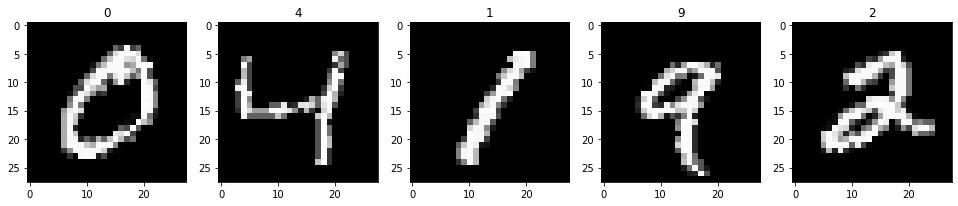

In [7]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage()(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img, cmap = "gray")
plt.show()

In [8]:
img, label=mnist_trainset[1]
print(img.shape,label)

torch.Size([1, 28, 28]) 0


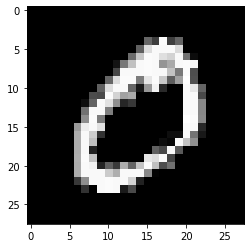

In [9]:
img = transforms.ToPILImage()(img)
plt.imshow(img, cmap="gray")

In [10]:
def denorm(image):
    return image * 0.5 + 0.5

def show_images(images, nmax=128):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(utils.make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=128):
    for images, _ in dataloader:
        print(images.shape)
        show_images(images, nmax)
        break

In [11]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu()
    image_grid = utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        
    plt.show()

torch.Size([128, 1, 28, 28])


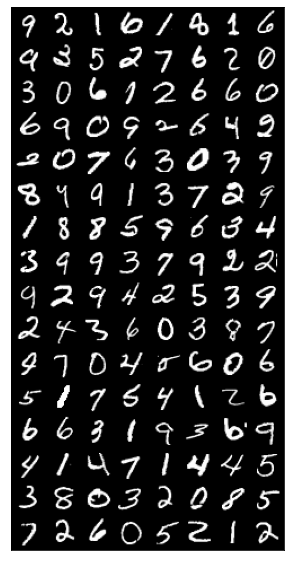

In [12]:
show_batch(train_dataloader)

In [13]:
num_classes = 10
z_d = 64 #noise size

In [14]:
def get_C_v_matrix(labels, train_batchsize):
    C_v = torch.zeros((train_batchsize,10,1))
    for i in range(train_batchsize):
      C_v[i,labels[i],:] = 1
    return C_v

In [15]:
def get_C_m_matrix(labels, train_batchsize):
  C_m = torch.zeros(train_batchsize,10, 28, 28)
  for i in range(train_batchsize):
    C_m[i,labels[i],:,:] = 1
  return C_m

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(74, 64, kernel_size=3, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(1)

    def forward(self, z):            # z = [128, 74, 1, 1]
        x = self.conv1(z)     # [128, 64, 3, 3]
        x = self.bn1(x)
        x = torch.tanh(x)
        x = self.conv2(x)       #([128, 128, 6, 6])
        x = self.bn2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.tanh(x)      #[128, 64, 13, 13]
        x = self.conv4(x)         # [128, 1, 28, 28]
        x = self.bn4(x)
        x = torch.relu(x)
        return x

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(11, 64, kernel_size=4, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.sigmoid(x)
        return x

In [25]:
generator = Generator().to(device) 
discriminator = Discriminator().to(device) 

In [26]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [27]:
generator.apply(weights_init)

Generator(
  (conv1): ConvTranspose2d(74, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
  (bn4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
discriminator.apply(weights_init)

Discriminator(
  (conv1): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  (bn3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [30]:
num_epochs = 10

generator_loss = []
discriminator_loss = []

lossG_mean = []
lossD_mean = []
cur_steps = 0
total_steps = 0


In [ ]:
for epoch in range(num_epochs):
    cur_steps = 0
    for i, (real_images, labels) in enumerate(train_dataloader):
        
        real_images = real_images.to(device) 
        labels = labels.to(device) 
        
        optimizer_d.zero_grad()
        batchsize = len(labels)
        # Train discriminator on fake images
        noise = torch.randn((batchsize, z_d,1))      #[128, 64, 1]
        C_v = get_C_v_matrix(labels, batchsize)      #([128, 10, 1])
        gen_input = torch.cat((noise, C_v), dim =1).to(device) 
        gen_input = gen_input.reshape((batchsize, 74,1,1))  #([128, 74, 1,1])

        fake_images = generator(gen_input).to(device)       #[128, 1, 28, 28]
        C_m = get_C_m_matrix(labels, batchsize).to(device)      #[128, 10, 28, 28]
        disc_input = torch.cat((fake_images,C_m ), dim =1).to(device)       #[128, 11, 28, 28]
        
        pred_fake = discriminator(disc_input.detach()).to(device)        # 128, 1, 1, 1]
        fake_labels = torch.zeros_like(pred_fake).to(device)         #[128, 1, 1, 1]
        loss_D_fake = criterion(pred_fake, fake_labels)

        # Train discriminator on real images
        disc_input_r = torch.cat((real_images,C_m),dim =1).to(device) 
        pred_real = discriminator(disc_input_r).to(device) 
        real_labels = torch.ones_like(pred_real).to(device) 
        loss_D_real = criterion(pred_real, real_labels)

        # Total discriminator loss and backpropagation
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_d.step()

        discriminator_loss.append(loss_D)

        # Train generator
        generator.zero_grad()
        pred_fake = discriminator(disc_input).to(device) 
        loss_G = criterion(pred_fake, real_labels)
        loss_G.backward()
        optimizer_g.step()

        generator_loss.append(loss_G)
        cur_steps += 1
        total_steps += 1

        # Output training stats
        print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(train_dataloader)}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")  
        

    fake_images = generator(gen_input) 
    show_tensor_images(real_images, show_fig=True, epoch=epoch) 
    show_tensor_images(fake_images, show_fig=True, epoch=epoch) 
    gen_mean = sum(generator_loss[-cur_steps:]) / cur_steps
    disc_mean = sum(discriminator_loss[-cur_steps:]) / cur_steps

    lossG_mean.append(gen_mean) 
    lossG_mean.append(disc_mean) 

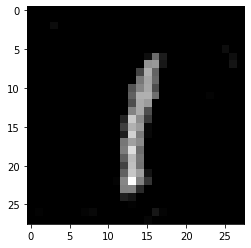

In [34]:
plt.imshow(fake_images[9].cpu().detach().permute(1,2,0),cmap="gray")

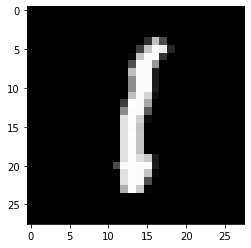

In [35]:
plt.imshow(real_images[9].cpu().detach().permute(1,2,0),cmap="gray")

In [51]:
generator_loss = torch.tensor(generator_loss).detach().cpu().numpy()
discriminator_loss= torch.tensor(discriminator_loss).detach().cpu().numpy()

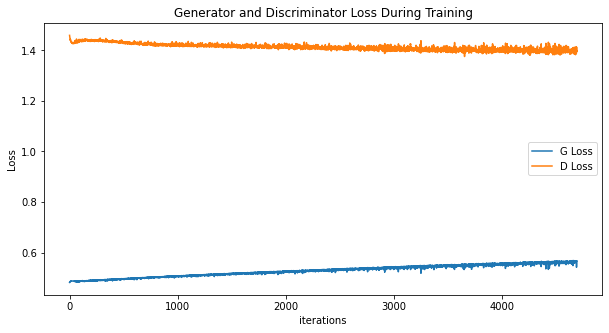

In [52]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="G Loss")
plt.plot(discriminator_loss,label="D Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()